In [202]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [203]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [204]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph
from langchain_teddynote.tools.tavily import TavilySearch

In [205]:
from langchain.schema import HumanMessage, AIMessage
from langchain_core.messages import ToolMessage

In [206]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [207]:
llm = ChatOpenAI( 
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

In [208]:
tool = TavilySearch(max_results=1)      # 검색 도구 생성
tools = [tool]                          # 도구 목록에 넣기  

In [209]:
# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

In [210]:
def chatbot(state: State):
    print(f'=='*50)
    print('===== chatbot() 함수 시작 =====')
    print(f"chatbot() 으로 넘어온 메시지 :")
    print(state['messages'])
    print(f"메시지 개수 : {len(state['messages'])}")
    print()

    answer = llm_with_tools.invoke(state['messages'])

    print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    print(f'[도구 사용 LLM 실행 결과 answer]: {answer}')
    print(f'[도구 사용 LLM 실행 결과 additional_kwargs]: {answer.additional_kwargs}')

    print('===== chatbot() 함수  끝 =====')
    print(f'=='*50)
    print()

    return {'messages': [answer]}

In [211]:
question = "대구의 유명한 수학학원을 알려줘."

state = State(messages=[('user', question)])
chatbot(state)

===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[('user', '대구의 유명한 수학학원을 알려줘.')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 
[도구 사용 LLM 실행 결과 answer]: content='' additional_kwargs={'tool_calls': [{'id': 'call_5wDLAXzgrW7zSVjnXqgGalGr', 'function': {'arguments': '{"query":"대구 유명 수학 학원"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 103, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-a5ffe2c4-877c-4d69-b1c4-d2527859168e-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 유명 수학 학원'}, 'id': 'call_5wDLAXzgrW7zSVjnXqgGalGr', 'type': 'tool_call'}] usage_metadata={'inpu

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5wDLAXzgrW7zSVjnXqgGalGr', 'function': {'arguments': '{"query":"대구 유명 수학 학원"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 103, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a5ffe2c4-877c-4d69-b1c4-d2527859168e-0', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대구 유명 수학 학원'}, 'id': 'call_5wDLAXzgrW7zSVjnXqgGalGr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 103, 'output_tokens': 24, 'total_tokens': 127, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_t

In [212]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        self.tools_list = {tool.name: tool for tool in tools}
        print(f'======================================================')
        print('[BasicToolNode]')
        print('도구 호출 생성자')
        print(f'tools_list: {self.tools_list}')
        print(f'======================================================')
    
    def __call__(self, inputs: dict):
        if messages := inputs.get('messages', []):
            message = messages[-1]
        else:
            raise ValueError('No message found in input')
        
        print()
        print(f'======================================================')
        print('[BasicToolNode] call')
        #print('도구 호출로 갔을 때')
        #print('message.tool_calls:', message.tool_calls)
        #print(f'======================================================')

        outputs = []

        for tool_call in message.tool_calls:    # message의 tool_calls 속성이 있는것은 도구 호출을 필요한 메시지가 있는 경우
            print(f'도구 호출이 필요한 경우: ')
            # print(f'도구 호출 : {tool_call}')
            print(f"도구 호출 이름: {tool_call['name']}")
            print(f"도구 호출 인자 : {tool_call['args']}")

            tool_result = self.tools_list[tool_call['name']].invoke(tool_call['args'])
            print(f'도구 호출 결과 : {tool_result}')                                            
        
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False), 
                    name=tool_call['name'], 
                    tool_call_id=tool_call['id']
                )
            )
            
        print('[BasicToolNode] call 끝')
        print(f'======================================================')
        print()

        return {'messages': outputs}    

In [213]:
# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])   

[BasicToolNode]
도구 호출 생성자
tools_list: {'tavily_web_search': TavilySearch(client=<tavily.tavily.TavilyClient object at 0x000001D5F20459D0>, max_results=1)}


In [214]:
from langchain_core.runnables import RunnableLambda

tool_node_runnable = RunnableLambda(tool_node)

In [215]:
sample_input = {
    "messages": [
        HumanMessage(content="대구 동성로 떡볶이에 대해서 알려줘"),
        AIMessage(
            content="",
            tool_calls=[{
                "name": 'tavily_web_search',            
                "args": {"query": "대구 동성로 떡볶이"},
                "id": "99c32be8-e500-4b2c-9675-34ab45fa6ab5"
            }]
        )
    ]
}

result = tool_node(sample_input)

for msg in result["messages"]:
        print(f"- {msg.name}: {msg.content}")


[BasicToolNode] call
도구 호출이 필요한 경우: 
도구 호출 이름: tavily_web_search
도구 호출 인자 : {'query': '대구 동성로 떡볶이'}
도구 호출 결과 : [{'title': '대구 동성로 맛집 추천 추억의 동성로 떡볶이 본점 : 네이버 블로그', 'url': 'https://m.blog.naver.com/cmj3464/223699584675', 'content': '대구 동성로 맛집 추천 추억의 동성로 떡볶이 본점 : 네이버 블로그 대구 동성로 맛집 추천 추억의 동성로 떡볶이 본점 동성로 떡볶이 본점을 방문했어요. 그럼 지금부터 동성로 떡볶이 포스팅 시작해볼께요🤗 30년 전통 즉석 떡볶이 본점 대구 동성로에 위치한 “동성로 떡볶이” 합리적인 가격에 다양한 사리를 추가해서 자기만의 떡볶이를 만들어 먹을수 있습니다🤗 ▫️주소 - 대구 중구 동성로 19-7 ▫️도보이용시 - 지하철 중앙로역 2번 출구에서 206m ▫️이용시간 - 10:00 ~ 22:00(라스터오더 21:00) ▫️주차 - 전용주차장없음, 영스퀘어 주차장이용 #대구맛집 #대구맛집추천 #대구동성로맛집 #대구떡볶이 #떡볶이 #동성로떡볶이 #대구동성로데이트 #클파워챌린지 #하이라이트챌린지 m.blog.naver.com 동성로 떡볶이 먹고나면 이 볶음밥을 빼먹을 수 없는데요!! 대구에서 떡볶이를 먹고 싶다면 동성로 떡볶이 본점은 절대 놓치지 말아야 할 맛집인거 같아요 ㅎㅎ 대구떡볶이 #떡볶이 #떡볶이 {"title":"대구 동성로 맛집 추천 추억의 동성로 떡볶이 본점","source":"https://blog.naver.com/cmj3464/223699584675","blogName":"soy정이의 ..","domainIdOrBlogId":"cmj3464","nicknameOrBlogId":"SOY정이","logNo":223699584675,"smartEditorVersion":4,"meDisplay":true,"lineDisplay":true,"outsideD

In [216]:
from langgraph.graph import StateGraph, START, END

def route_tools(state: State):

    if messages := state.get('messages', []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    print()
    print('===== 라우터 노드 =====')
    print(f"라우터 노드로 넘어온 chatbot() 에서 생성한 state 메시지: ")
    print(ai_message.additional_kwargs)

    # print('========================================================================')
    # print('라우터에서 실행결과')
    # print('route_tool content:', ai_message.content)
    # print('route_tool:', ai_message.additional_kwargs)
    # print('========================================================================\n\n')

    if hasattr(ai_message, 'tool_calls') and len(ai_message.tool_calls) > 0:
        print(f'라우터 [tools] -> {ai_message.tool_calls}')
        print(f'라우터 리턴: tools')
        print('===== 라우터 노드 끝 =====')
        print()

        return 'tools'
    
    
    print(f'라우터 리턴: {END}')
    print('===== 라우터 노드 끝 =====')
    print()
    
    return END

In [217]:
state_with_tools = {
    "messages": [
        HumanMessage(
            content="대한민국 수도에 대해서 검색해줘",
            id='6e0ff6a0-d790-42a0-ae24-28172c7feabc'
        ),
        AIMessage(
            content="",
            tool_calls=[{
                "name": "tavily_web_search",                        
                "args": {"query": "대한민국 수도"},
                "id": "call_k6ljrhTRP8dz8FwNrtbyyG3K"
            }],
            additional_kwargs={
                "tool_calls": [{
                    "id": "call_k6ljrhTRP8dz8FwNrtbyyG3K",
                    "function": {
                        "arguments": json.dumps({"query": "대한민국 수도"}),
                        "name": "tavily_web_search"                     
                    },
                    "type": "function"
                }],
                "refusal": None
            },
            response_metadata={
                "token_usage": {
                    "completion_tokens": 20,
                    "prompt_tokens": 99,
                    "total_tokens": 119
                },
                "model_name": "gpt-4o-mini-2024-07-18"
            },
            id='run-164b42b2-a16c-4ea8-8a2e-94da55991426-0'
        )
    ]
}


route_tools(state_with_tools)


===== 라우터 노드 =====
라우터 노드로 넘어온 chatbot() 에서 생성한 state 메시지: 
{'tool_calls': [{'id': 'call_k6ljrhTRP8dz8FwNrtbyyG3K', 'function': {'arguments': '{"query": "\\ub300\\ud55c\\ubbfc\\uad6d \\uc218\\ub3c4"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None}
라우터 [tools] -> [{'name': 'tavily_web_search', 'args': {'query': '대한민국 수도'}, 'id': 'call_k6ljrhTRP8dz8FwNrtbyyG3K', 'type': 'tool_call'}]
라우터 리턴: tools
===== 라우터 노드 끝 =====



'tools'

In [218]:
graph_builder = StateGraph(State)

In [219]:
graph_builder.add_node('chatbot', chatbot)

In [220]:
# 그래프에 도구 노드 추가
graph_builder.add_node('tools', tool_node) 

In [221]:
graph_builder.add_conditional_edges(
    source='chatbot', 
    path=route_tools, 
    path_map={'tools': 'tools', END: END}
)

In [222]:
graph_builder.add_edge('tools', 'chatbot')

In [223]:
graph_builder.add_edge(START, 'chatbot')

In [224]:
graph = graph_builder.compile()

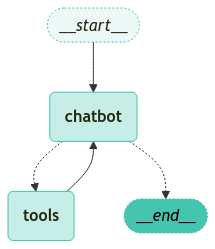

In [225]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

In [ ]:
import json

question = '대한민국 수도에 대해서 검색해줘'

state = State(messages=[('user', question)])

for event in graph.stream(state):
    print()
    print('===== 여기서 시작 =====')
    print('[event] 바깥 for 시작')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print()

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            # print(f"[해당 노드 값] content: {value['messages'][-1].content}")
            # print(f"additional_kwargs: {value['messages'][-1].additional_kwargs}")
            print('==================== END HumanMessage ====================')
            print()
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] value content: {value['messages'][-1].content}")
            # print(f"addtional_kwargs: {value['messages'][-1].additional_kwargs}")

            if 'tool_calls' in value['messages'][-1].additional_kwargs:
                # print(f"additional_kwargs tool_calls: {value['messages'][-1].additional_kwargs['tool_calls']}")
                tool_calls = value['messages'][-1].additional_kwargs['tool_calls']

                for call in tool_calls:
                    if 'function' in call:
                        arguments = json.loads(call['function']['arguments'])
                        name = call['function']['name']

                        print(f"도구 이름 : {name}")
                        print(f"Arguments: {arguments}")
            else:
                print("additional_kwargs tool_calls: None")
            print('==================== END AIMessage ====================')    

        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            content = json.loads(value['messages'][-1].content)

            if content and isinstance(content, list) and len(content) > 0:
                print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")
            else:
                print("No content or invalid content format in ToolMessage")

            print('==================== END ToolMessage ====================')   

        print()
        
    print('바깥 for 끝')
    print('===== 여기서 끝 =====') 
    print()

===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[HumanMessage(content='대한민국 수도에 대해서 검색해줘', additional_kwargs={}, response_metadata={}, id='9f115984-643a-4cf4-8c5d-05fcfa5c935e')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 
[도구 사용 LLM 실행 결과 answer]: content='' additional_kwargs={'tool_calls': [{'id': 'call_ppJLoIsSG8K5EJ77kczXDajs', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 99, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-1467618d-85f6-4a6a-bfb3-45453e559d36-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '대한민국

In [227]:
from langchain_teddynote.messages import display_message_tree

inputs = {"messages": "대한민국 수도에 대해서 검색해줘"}

for event in graph.stream(input=inputs, stream_mode='values'):
    for key, value in event.items():
        print(f'==========\nSTEP: {key} \n==========\n')
        display_message_tree(value[-1])

STEP: messages 

    content: "대한민국 수도에 대해서 검색해줘"
    additional_kwargs: {}
    response_metadata: {}
    type: "human"
    name: None
    id: "14f2af56-a420-4ea2-b9bf-7ddf80bde258"
    example: False
===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[HumanMessage(content='대한민국 수도에 대해서 검색해줘', additional_kwargs={}, response_metadata={}, id='14f2af56-a420-4ea2-b9bf-7ddf80bde258')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 
[도구 사용 LLM 실행 결과 answer]: content='' additional_kwargs={'tool_calls': [{'id': 'call_8Is8q52MHQunc0FBQRCmbsps', 'function': {'arguments': '{"query":"대한민국 수도"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 99, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 